# Day 26: Feature Selection + Advanced Engineering

## Foundation Drilling

In [1]:
# Standard Week 3 data load (use in all Foundation Drilling)
from sklearn.datasets import fetch_california_housing
import pandas as pd

housing = fetch_california_housing(as_frame=True)
df = housing.frame
X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']

# Verify
print(df.shape)  # (20640, 9)
print(df.columns.tolist())

(20640, 9)
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']


### Part 1: Python Fundamentals & Libraries

**Focus:** sorted() with key parameter (new pattern)

In [2]:
# New pattern: sorted() with custom key
# Basic pattern
# sorted(iterable, key=function, reverse=False)

# Real example
# words = ['banana', 'pie', 'Washington', 'a']
# by_length = sorted(words, key=len)  # ['a', 'pie', 'banana', 'Washington']
# Translation: "Sort by the result of applying function to each element"

# Task 1: Sort a list of numbers by their absolute value

numbers = [-5, 2, -1, 8, -3]
numbers_sorted = sorted(numbers, key=abs)
print(numbers_sorted)

# Use sorted() with key=abs

[-1, 2, -3, -5, 8]


In [3]:
# Task 2: Sort a list of dictionaries by a specific key
people = [{'name': 'Alice', 'age': 30}, {'name': 'Bob', 'age': 25}, {'name': 'Carol', 'age': 35}]
# Sort by age using sorted() with key=lambda
# basic pattern
# sorted(iterable, key=lambda item: item['key_name'])

people_sorted = sorted(people, key=lambda person: person['age'])
print(people_sorted)

[{'name': 'Bob', 'age': 25}, {'name': 'Alice', 'age': 30}, {'name': 'Carol', 'age': 35}]


In [4]:
# Task 3: Sort DataFrame columns by their mean value (advanced)
# Hint: df[sorted(df.columns, key=lambda col: df[col].mean())]
# Translation: For each column name, calculate df[column_name].mean()

sorted_cols = sorted(df.columns, key=lambda col: df[col].mean())
print(sorted_cols)

['Longitude', 'AveBedrms', 'MedHouseVal', 'AveOccup', 'MedInc', 'AveRooms', 'HouseAge', 'Latitude', 'Population']


### Part 2: Feature Engineering Patterns (learned Day 25)

**Focus:** Creating ratio features and new columns

In [5]:
# Task: Using California Housing data, create these features from memory:

# 1. Bedroom ratio (bedrooms as fraction of total rooms)
df['bedroom_ratio'] = df['AveBedrms'] / df['AveRooms']
# Translation: "What percentage of rooms are bedrooms?"

# 2. Rooms per person (rooms divided by household size)
df['rooms_per_person'] = df['AveRooms'] / df['AveOccup']
# Translation: "How many rooms per person in the household?"

# Checkpoint: Verify these match what you did on Day 25
print(df[['AveRooms', 'AveBedrms', 'AveOccup', 'bedroom_ratio', 'rooms_per_person']].head())

# Check for NaN/inf
print(f"\nNaN counts:\n{df[['bedroom_ratio', 'rooms_per_person']].isna().sum()}")


   AveRooms  AveBedrms  AveOccup  bedroom_ratio  rooms_per_person
0  6.984127   1.023810  2.555556       0.146591          2.732919
1  6.238137   0.971880  2.109842       0.155797          2.956685
2  8.288136   1.073446  2.802260       0.129516          2.957661
3  5.817352   1.073059  2.547945       0.184458          2.283154
4  6.281853   1.081081  2.181467       0.172096          2.879646

NaN counts:
bedroom_ratio       0
rooms_per_person    0
dtype: int64


In [6]:
# Notes on Math Logic

# Pattern
# "thing_per_unit" = thing / unit

# Examples
# miles_per_hour = miles / hours          # 60 miles / 2 hours = 30 mph
# price_per_square_foot = price / sqft    # $300,000 / 1,500 sqft = $200/sqft
# rooms_per_person = rooms / people       # 6 rooms / 3 people = 2 rooms per person

# Feature 1: Bedroom Ratio

# ❌ Incorrect VERSION (backwards)
# df['bedroom_ratio'] = df['AveRooms'] / df['AveBedrms']
# This gives: "rooms per bedroom"
# Example: 5 rooms / 2 bedrooms = 2.5 rooms per bedroom
# Interpretation: "For every bedroom, there are 2.5 total rooms" (confusing!)

# ✅ CORRECT VERSION
# df['bedroom_ratio'] = df['AveBedrms'] / df['AveRooms']
# This gives: "bedrooms as fraction of total rooms"
# Example: 2 bedrooms / 5 rooms = 0.4 = 40%
# Interpretation: "40% of the rooms are bedrooms" (clear!)

# Feature 2: Rooms Per Person

# ❌ Incorrect VERSION (backwards)
# df['rooms_per_person'] = df['AveOccup'] / df['AveRooms']
# This gives: "people per room"
# Example: 3 people / 5 rooms = 0.6 people per room
# Interpretation: "Each room has 0.6 people" (crowded = LOW value... backwards!)

# ✅ CORRECT VERSION
# df['rooms_per_person'] = df['AveRooms'] / df['AveOccup']
# This gives: "rooms per person"
# Example: 5 rooms / 3 people = 1.67 rooms per person
# Interpretation: "Each person has 1.67 rooms" (spacious = HIGH value... correct!)

## BLOCK 0: Rebuild Day 25 Environment

**Load California Housing with your engineered features:**

In [7]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
housing = fetch_california_housing(as_frame=True)
df = housing.frame

# Recreate Day 25 engineered features
df['bedroom_ratio'] = df['AveBedrms'] / df['AveRooms']
df['rooms_per_person'] = df['AveRooms'] / df['AveOccup']

# Verify
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")


Shape: (20640, 11)
Columns: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal', 'bedroom_ratio', 'rooms_per_person']


## BLOCK 1: Feature Importance Analysis

**Goal:** Understand which features actually help your model.

In [9]:
# Task 1: Correlation with target

# Basic pattern
correlations = df.corr()['MedHouseVal'].sort_values(ascending=False)

# Real example
print("=== CORRELATION WITH TARGET ===")
print(correlations)

# Translation: "Higher absolute correlation = more predictive (but beware multicollinearity)"


=== CORRELATION WITH TARGET ===
MedHouseVal         1.000000
MedInc              0.688075
rooms_per_person    0.209482
AveRooms            0.151948
HouseAge            0.105623
AveOccup           -0.023737
Population         -0.024650
Longitude          -0.045967
AveBedrms          -0.046701
Latitude           -0.144160
bedroom_ratio      -0.255624
Name: MedHouseVal, dtype: float64


In [10]:
# Notes

# 1. Correlation vs Coefficients - Different Questions
# Correlation (today's Task 1):

# Question: "How does THIS feature relate to target, ignoring all other features?"
# MedInc → MedHouseVal: 0.688 (strong simple relationship)

# Coefficients (yesterday's model):

# Question: "How much does THIS feature contribute WHILE CONTROLLING for all other features?"
# MedInc coefficient: 0.414 (lower because other features "steal" some of its credit)

In [11]:
# Task 2: Coefficient magnitude from fitted model

# Using your Day 25 model setup
feature_cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
                'AveOccup', 'Latitude', 'Longitude', 'bedroom_ratio', 'rooms_per_person']

X = df[feature_cols]
y = df['MedHouseVal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Feature importance by coefficient
importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': model.coef_,
    'abs_coefficient': np.abs(model.coef_)
}).sort_values('abs_coefficient', ascending=False)

print("\n=== FEATURE IMPORTANCE (Coefficient Magnitude) ===")
print(importance)



=== FEATURE IMPORTANCE (Coefficient Magnitude) ===
            feature  coefficient  abs_coefficient
8     bedroom_ratio     4.163238         4.163238
3         AveBedrms    -0.520433         0.520433
9  rooms_per_person     0.461493         0.461493
7         Longitude    -0.416072         0.416072
0            MedInc     0.414928         0.414928
6          Latitude    -0.414825         0.414825
2          AveRooms    -0.061534         0.061534
1          HouseAge     0.010191         0.010191
5          AveOccup    -0.001541         0.001541
4        Population     0.000028         0.000028


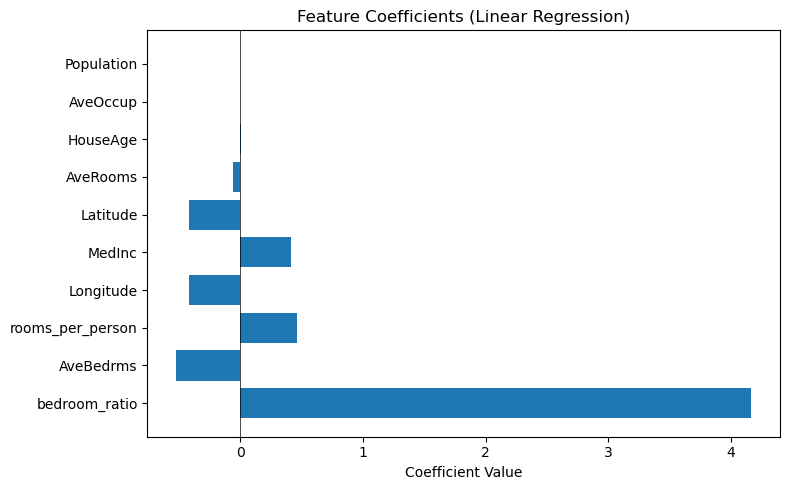

In [12]:
# Task 3: Visualize feature importance

# Horizontal bar chart of coefficients
plt.figure(figsize=(8, 5))
plt.barh(importance['feature'], importance['coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Feature Coefficients (Linear Regression)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

## BLOCK 2: Feature Selection - Drop Weak Features

**New Pattern — Selective feature removal:**

**Basic pattern: Compare model with all features vs subset**
1. Train with all features → record metrics
2. Remove lowest-importance feature → retrain → record metrics
3. If metrics improved or stayed same → keep the removal
4. Repeat

Translation: "Simpler models that perform equally well are better (Occam's razor)"

In [13]:
# **Task 1:** Identify candidates for removal
# From your importance analysis, which features have:

# - Very small coefficients (close to 0)?
# - Low correlation with target?
# - High correlation with OTHER features (redundant)?

# Check for multicollinearity (features correlated with each other)
feature_corr = df[feature_cols].corr()

# Find highly correlated pairs (abs > 0.7)
high_corr_pairs = []
for i in range(len(feature_cols)):
    for j in range(i+1, len(feature_cols)):
        if abs(feature_corr.iloc[i, j]) > 0.7:
            high_corr_pairs.append((feature_cols[i], feature_cols[j], feature_corr.iloc[i, j]))

print("=== HIGHLY CORRELATED FEATURE PAIRS ===")
for f1, f2, corr in high_corr_pairs:
    print(f"{f1} <-> {f2}: {corr:.3f}")


=== HIGHLY CORRELATED FEATURE PAIRS ===
AveRooms <-> AveBedrms: 0.848
AveRooms <-> rooms_per_person: 0.887
AveBedrms <-> rooms_per_person: 0.825
Latitude <-> Longitude: -0.925


In [15]:
# Task 2: Train model WITHOUT weak/redundant features

# Remove 1-2 features you identified as weak
reduced_features = [f for f in feature_cols if f not in ['Population', 'AveOccup']]

X_reduced = df[reduced_features]
X_train_red, X_test_red, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

model_reduced = LinearRegression()
model_reduced.fit(X_train_red, y_train)
preds_reduced = model_reduced.predict(X_test_red)

r2_reduced = r2_score(y_test, preds_reduced)
mae_reduced = mean_absolute_error(y_test, preds_reduced)

print(f"=== REDUCED MODEL ({len(reduced_features)} features) ===")
print(f"R²: {r2_reduced:.4f}")
print(f"MAE: ${mae_reduced * 100000:,.0f}")
print(f"Features removed: {set(feature_cols) - set(reduced_features)}")


=== REDUCED MODEL (8 features) ===
R²: 0.6511
MAE: $48,709
Features removed: {'AveOccup', 'Population'}


In [17]:
# Task 3: Compare full vs reduced

# Did removing features hurt performance?
print("=== COMPARISON ===")
print(f"Full model R²: {r2_score(y_test, model.predict(X_test)):.4f}")
print(f"Reduced model R²: {r2_reduced:.4f}")
print(f"Difference: {r2_reduced - r2_score(y_test, model.predict(X_test)):+.4f}")

# If reduced is similar or better → simpler model wins


=== COMPARISON ===
Full model R²: 0.6519
Reduced model R²: 0.6511
Difference: -0.0008


## BLOCK 3: Try New Feature Types

**Goal:** Experiment with interaction and polynomial features.

**New Pattern — Interaction features:**

- Basic pattern
- df['feature_A_x_feature_B'] = df['feature_A'] * df['feature_B']

- Real example
- df['income_x_rooms'] = df['MedInc'] * df['AveRooms']
- Translation: "Capture combined effect - maybe high income + many rooms = much higher value"

**When to use: When you suspect features have synergistic effect**


In [19]:
# Task 1: Create 2 interaction features

# Income interactions (income might amplify other factors)
df['income_x_age'] = df['MedInc'] * df['HouseAge']
df['income_x_bedroom_ratio'] = df['MedInc'] * df['bedroom_ratio']

# Test if they help
test_features = reduced_features + ['income_x_age', 'income_x_bedroom_ratio']

# ... train and evaluate

X_interaction = df[test_features]
X_train_int, X_test_int, y_train, y_test = train_test_split(X_interaction, y, test_size=0.2, random_state=42)

model_inter = LinearRegression()
model_inter.fit(X_train_int, y_train)
preds_inter = model_inter.predict(X_test_int)

r2_inter = r2_score(y_test, preds_inter)
mae_inter = mean_absolute_error(y_test, preds_inter)

print(f"=== INTERACTION MODEL ({len(test_features)} features) ===")
print(f"R²: {r2_inter:.4f}")
print(f"MAE: ${mae_inter * 100000:,.0f}")
print(f"Features added: {set(test_features) - set(feature_cols)}")

=== INTERACTION MODEL (10 features) ===
R²: 0.6497
MAE: $48,670
Features added: {'income_x_bedroom_ratio', 'income_x_age'}


### **New Pattern — Binning continuous variables**

In [20]:
# Basic pattern
# df['feature_binned'] = pd.cut(df['feature'], bins=N, labels=False)

# Real example
# df['income_category'] = pd.cut(df['MedInc'], bins=[0, 2, 4, 6, 15], labels=['low', 'medium', 'high', 'very_high'])
# Translation: "Convert continuous to categories - useful when relationship isn't linear"

# One-hot encode for model
# income_dummies = pd.get_dummies(df['income_category'], prefix='income')


In [26]:
# Task 2: Try binned income category

# Replace MedInc with income_bin (test if binning is better)
binned_features = [f for f in reduced_features if f != 'MedInc'] + ['income_bin']

X_binned = df[binned_features]
X_train_bin, X_test_bin, y_train, y_test = train_test_split(X_binned, y, test_size=0.2, random_state=42)

model_binned = LinearRegression()
model_binned.fit(X_train_bin, y_train)
preds_binned = model_binned.predict(X_test_bin)

r2_binned = r2_score(y_test, preds_binned)
mae_binned = mean_absolute_error(y_test, preds_binned)

print(f"=== BINNED INCOME (REPLACING continuous) ===")
print(f"Features: {binned_features}")
print(f"R²: {r2_binned:.4f}")
print(f"MAE: ${mae_binned * 100000:,.0f}")

print(f"\n=== COMPARISON ===")
print(f"Continuous MedInc: R² = 0.6511")
print(f"Binned income_bin: R² = {r2_binned:.4f}")
print(f"Difference: {r2_binned - 0.6511:+.4f}")

=== BINNED INCOME (REPLACING continuous) ===
Features: ['HouseAge', 'AveRooms', 'AveBedrms', 'Latitude', 'Longitude', 'bedroom_ratio', 'rooms_per_person', 'income_bin']
R²: 0.6015
MAE: $53,771

=== COMPARISON ===
Continuous MedInc: R² = 0.6511
Binned income_bin: R² = 0.6015
Difference: -0.0496


## BLOCK 4: Final Model Comparison

In [27]:
# Task: Create summary of all experiments

print("=== DAY 26 FEATURE ENGINEERING SUMMARY ===")
print(f"Baseline (Day 25, 10 features):      R² = 0.6519")
print(f"Reduced (removed 2 weak):            R² = 0.6511  (8 features)")
print(f"+ Interactions (income × features):  R² = 0.6497  (hurt)")
print(f"Binned income (replace continuous):  R² = 0.6015  (hurt badly)")
print(f"\nBest model: Reduced (8 features)")
print(f"Features: {reduced_features}")

=== DAY 26 FEATURE ENGINEERING SUMMARY ===
Baseline (Day 25, 10 features):      R² = 0.6519
Reduced (removed 2 weak):            R² = 0.6511  (8 features)
+ Interactions (income × features):  R² = 0.6497  (hurt)
Binned income (replace continuous):  R² = 0.6015  (hurt badly)

Best model: Reduced (8 features)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Latitude', 'Longitude', 'bedroom_ratio', 'rooms_per_person']
